# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
%matplotlib inline
import pandas as pd

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [3]:
data.shape

(13150, 10)

In [5]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [8]:
#import libraries section
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from datetime import datetime
import os
from sklearn.ensemble import RandomForestClassifier


Declaracion de finciones

In [9]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)


In [10]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [11]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)          
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [12]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    #print(X.columns)
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
    
    
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [13]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [14]:
tree = tree_grow(X_train,y_train, level = 0, min_gain=0.001, max_depth=5, num_pct=10)

In [15]:
tree

{'y_pred': 1,
 'y_prob': 0.5780753517930095,
 'level': 0,
 'split': [1, 52187.63636363637],
 'n_samples': 8810,
 'gain': 0.23872134898880762,
 'sl': {'y_pred': 1,
  'y_prob': 0.8391583452211127,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 5606,
  'gain': 0.03317687167496233,
  'sl': {'y_pred': 0,
   'y_prob': 0.36828644501278773,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 389,
   'gain': 0.05908490521197157,
   'sl': {'y_pred': 0,
    'y_prob': 0.08,
    'level': 3,
    'split': [2, 1.0],
    'n_samples': 98,
    'gain': 0.01707452211653898,
    'sl': {'y_pred': 0,
     'y_prob': 0.04597701149425287,
     'level': 4,
     'split': [1, 37722.0],
     'n_samples': 85,
     'gain': 0.001980228771650633,
     'sl': {'y_pred': 0,
      'y_prob': 0.12,
      'level': 5,
      'split': -1,
      'n_samples': 23,
      'gain': -1},
     'sr': {'y_pred': 0,
      'y_prob': 0.03125,
      'level': 5,
      'split': -1,
      'n_samples': 62,
      'gain': -1}},
    'sr': {'

In [16]:
y_pred = tree_predict(X_test, tree)

In [18]:
print('El F1 Score es: ',f1_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None))

El F1 Score es:  0.8930304795185401


In [19]:
print('La precisión del modelo es: ', accuracy_score(y_test, y_pred, normalize = True))

La precisión del modelo es:  0.8730414746543779


# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [20]:
# set a seed for reproducibility
np.random.seed(524)

n_samples = X_train.shape[0]
n_B = 10

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

In [21]:
# DataFrame for storing predicted price from each tree
y_pred = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])

# grow one tree for each bootstrap sample and make predictions on testing data
for i, sample in enumerate(samples):
    X_train_ = X_train.iloc[sample,:]
    y_train_ = y_train.iloc[sample]
    tree = tree_grow(X_train_,y_train_, level = 0, min_gain=0.001, max_depth=5, num_pct=10)
    y_pred[i] = tree_predict(X_test, tree)

In [22]:
y_pred.head()

,0,1,2,3,4,5,6,7,8,9
332784,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
146436,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
130476,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
85618,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
y_pred_df = y_pred.sum(axis=1)
y_pred_df.head(10)

332784     2.0
146436    10.0
130476    10.0
85618     10.0
75474      0.0
330419     0.0
205915    10.0
2836       6.0
250833    10.0
126784     0.0
dtype: float64

In [25]:
y_pred_mv = (y_pred.sum(axis=1) >= (n_B / 2)).astype(np.int)

print('La precisión del modelo es: ', accuracy_score(y_test, y_pred_mv, normalize = True))

La precisión del modelo es:  0.8785714285714286


# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [26]:
max_feature=8
X_train[np.random.choice(X_train.columns,np.random.choice(max_feature,1)+1, replace = False)].head()

,M_CamryXLE,Mileage,Year,M_Camry4dr
475678,0,141137,2012,0
23079,0,13671,2015,0
291651,0,58614,2013,0
277196,0,47704,2011,1
14923,0,37504,2016,0


In [27]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    features_desc = X.columns
    
    best_split = [0, 0, 0, '']  # j, split, gain, feature
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)          
            if gain > best_split[2]:
                best_split = [j, split, gain, features_desc[j]]
    
    return best_split

In [28]:
def tree_grow_rf(X, X_, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=None):

    random_data = os.urandom(4)
    seed = int.from_bytes(random_data, byteorder="big")+level

    np.random.seed(seed)
    
    if level != 0:
        
        if ((max_features is None) or (max_features <=0 or max_features>=X_.shape[1])):
            features = np.random.choice(X_.columns,np.random.choice(X_.shape[1],1)+1, replace = False)
            X=X_.loc[X.index,features]
        else:
            features = np.random.choice(X_.columns,np.random.choice(max_features,1)+1, replace = False)
            X=X_.loc[X.index,features]
    else:
        X=X_.loc[X.index,:]
        
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain, feature = best_split(X, y, num_pct)
    
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
      
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.loc[:, feature] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [feature, split]
    tree['gain'] = gain
    
    # Next iteration to each split
    
    tree['sl'] = tree_grow_rf(X_l, X_, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow_rf(X_r, X_, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [29]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        feature, split = tree['split']
        filter_l = (X.loc[:, feature] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [30]:
X_train_c = X_train
tree = tree_grow_rf(X_train, X_train_c, y_train, level = 0, min_gain=0.001, max_depth=5, num_pct=10, max_features=5)

In [31]:
y_pred = tree_predict(X_test, tree)

In [32]:
print('La precisión del modelo es: ', accuracy_score(y_test, y_pred, normalize = True))

La presición del modelo es:  0.8672811059907835


En este caso se observa que es ligeramente menos preciso que el bagging de 10.

In [33]:
accuracy = []
for i in range(len(X_train.columns)):
    tree = tree_grow_rf(X_train,X_train, y_train, level = 0, min_gain=0.001, max_depth=5, num_pct=10, max_features=i)
    y_pred = tree_predict(X_test, tree)
    accuracy.append((i,accuracy_score(y_test, y_pred, normalize = True)))


Text(0,0.5,'Accuracy')

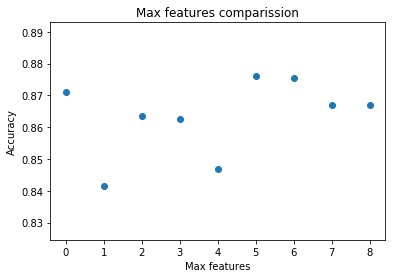

In [34]:
import matplotlib.pyplot as plt

plt.scatter(*zip(*accuracy))
plt.title('Max features comparission')
plt.xlabel('Max features')
plt.ylabel('Accuracy')

No se puede concluir que la precisión este relacionada con el número de max features.

# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [35]:
# set a seed for reproducibility
np.random.seed(127)

n_samples = X_train.shape[0]
n_B = 10

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

In [36]:
y_pred = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])
max_features = np.log(len(y_pred.columns)).astype(np.int)

for i, sample in enumerate(samples):
    X_train_ = X_train.iloc[sample, :]
    X_c = X_train
    y_train_ = y_train.iloc[sample]
    tree = tree_grow_rf(X_train_, X_c,y_train_, level = 0, min_gain=0.001, max_depth=5, num_pct=10, max_features=None)
    y_pred[i] = tree_predict(X_test, tree)

In [37]:
y_pred_df = y_pred.sum(axis=1)
y_pred_df.head()

332784     3.0
146436    10.0
130476    10.0
85618     10.0
75474      0.0
dtype: float64

In [39]:
y_pred_mv = (y_pred.sum(axis=1) >= (n_B / 2)).astype(np.int)

In [40]:
print('La precisión de este modelo es: ',accuracy_score(y_test, y_pred_mv, normalize = True))

La precisión de este modelo es:  0.8688940092165899


# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [41]:
rforest_reeg = RandomForestClassifier(n_estimators=10, max_features=X_train.shape[1], random_state=1, n_jobs=-1)

In [42]:
rforest_reeg.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [47]:
y_pred = rforest_reeg.predict(X_test)

In [50]:
print('La precisión de este modelo es: ',accuracy_score(y_test, y_pred, normalize = True))

La precisión de este modelo es:  0.8435483870967742


# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [88]:
# values to try for n_estimators
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
estimator_range = range(1, 100,10)

# Store average accuracy for each value of n_estimator
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

(Accuracy, Mejor n_estimators) (0.8407590301418161, 11)


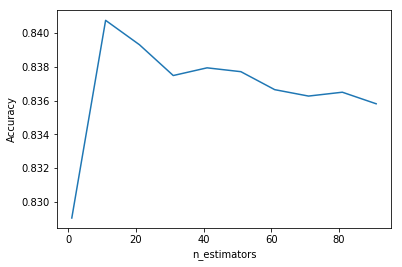

In [91]:
plt.plot(estimator_range, accuracy_scores)
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
print('(Accuracy, Mejor n_estimators)', sorted(zip(accuracy_scores,estimator_range))[::-1][0])

In [94]:
# values to try for max_features
feature_range = range(1, len(X.columns)+1)

# Store average accuracy for each max_feature
accuracy_scores = []

# use 5-fold cross-validation with each value of max_features
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=11, n_jobs=-1, max_features=feature)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

(Accuracy, Mejor max_features) (0.8478316497416196, 9)


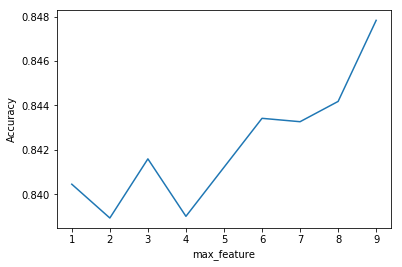

In [95]:
plt.plot(feature_range,accuracy_scores)
plt.xlabel('max_feature')
plt.ylabel('Accuracy')
print('(Accuracy, Mejor max_features)', sorted(zip(accuracy_scores,feature_range))[::-1][0])

In [97]:
# values to try for max_depth
depth_range = range(440,900,50)

# Store average accuracy for each max_depth value
accuracy_scores = []

#
for depth in depth_range:
    cfl = RandomForestClassifier(n_estimators=11, max_features=7, max_depth=depth, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

(Accuracy, Mejor max_depth) (0.8476796453298887, 840)


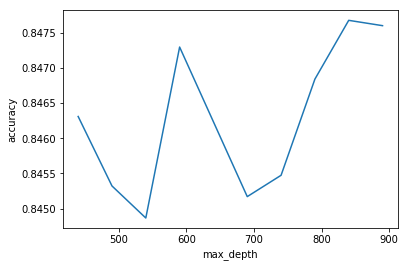

In [98]:
plt.plot(depth_range,accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
print('(Accuracy, Mejor max_depth)', sorted(zip(accuracy_scores,depth_range))[::-1][0])

In [101]:
clf = RandomForestClassifier(n_estimators=11, max_features=7, max_depth=740, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('La precisión de este modelo es: ', format(accuracy_score(y_test, y_pred)))

La precisión de este modelo es:  0.8442396313364056
